Conda environment creation:
```
conda create --name=baysor python=3.10 numpy jupyter matplotlib seaborn tqdm
```

In [1]:
import os, glob
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# modify path so we can import a custom module
import sys
sys.path.append('.')

from segmentation import SpotTable, run_baysor

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
data_path = '../../../data/merfish_test/202203031129_60988224_VMSC01001/'
tile_path = data_path + 'tiles/'
raw_data_file = data_path + 'detected_transcripts.csv'
baysor_bin = '../../../Baysor/bin/Baysor'

### Load x,y,z,gene from merfish data

In [5]:
def load_and_cache_merfish(csv_file):
    cache_file = os.path.splitext(csv_file)[0] + '.npz'
    if not os.path.exists(cache_file):
        print("Loading csv..")
        dtype = [('x', 'float32'), ('y', 'float32'), ('z', 'float32'), ('gene', 'int')]
        data = np.loadtxt(csv_file, skiprows=1, usecols=[2,3,4,9], delimiter=',', dtype=dtype)
        print("Recompressing to npz..")
        np.savez_compressed(cache_file, data)
    else:
        print("Loading from cache..")
        data = np.load(cache_file)['arr_0']
    return data

In [6]:
data = load_and_cache_merfish(raw_data_file)

Loading from cache..


### Create a SpotTable instance

In [7]:
spot_table = SpotTable(data)

### Split into tiles

In [8]:
tiles = spot_table.split_tiles(max_spots_per_tile=5000000, overlap=30)

  0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
# How big are our tiles?
sizes = [len(t) for t in tiles]
print(f"Tile size:  min={min(sizes)/1e6:0.1f}M  max={max(sizes)/1e6:0.1f}M  med={np.median(sizes)/1e6:0.1f}M")

Tile size:  min=4.3M  max=4.9M  med=4.6M


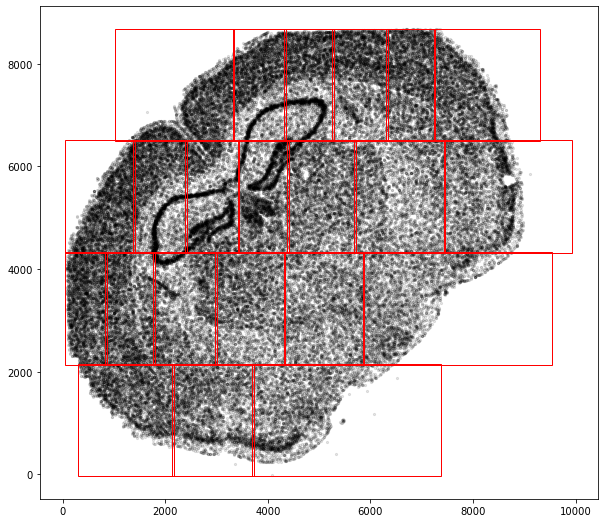

In [10]:
# plot tile regions
import matplotlib.patches
fig, ax = plt.subplots(figsize=(10, 10))
ds = len(spot_table) // 100000
ax.scatter(spot_table.data['x'][::ds], spot_table.data['y'][::ds], s=5, color=(0, 0, 0, 0.1))
ax.set_aspect('equal')

for tile in tiles:
    tile.plot_rect(ax=ax, color='r')

### Save all tiles to disk

In [11]:
if not os.path.exists(tile_path):
    os.mkdir(tile_path)
    
# write a CSV and json file for each tile
for i, tile in tqdm(list(enumerate(tiles))):
    csv_file = tile_path + f'tile_{i}.csv'
    tile.save_csv(csv_file)
    tile.csv_file = csv_file
    print(f"Wrote {csv_file}")
    
    json_file = tile_path + f'tile_{i}.json'
    tile.save_json(json_file)
    tile.json_file = json_file
    print(f"Wrote {json_file}")    

  0%|          | 0/22 [00:00<?, ?it/s]

Wrote ../../../data/merfish_test/202203031129_60988224_VMSC01001/tiles/tile_0.csv
Wrote ../../../data/merfish_test/202203031129_60988224_VMSC01001/tiles/tile_0.json
Wrote ../../../data/merfish_test/202203031129_60988224_VMSC01001/tiles/tile_1.csv
Wrote ../../../data/merfish_test/202203031129_60988224_VMSC01001/tiles/tile_1.json
Wrote ../../../data/merfish_test/202203031129_60988224_VMSC01001/tiles/tile_2.csv
Wrote ../../../data/merfish_test/202203031129_60988224_VMSC01001/tiles/tile_2.json
Wrote ../../../data/merfish_test/202203031129_60988224_VMSC01001/tiles/tile_3.csv
Wrote ../../../data/merfish_test/202203031129_60988224_VMSC01001/tiles/tile_3.json
Wrote ../../../data/merfish_test/202203031129_60988224_VMSC01001/tiles/tile_4.csv
Wrote ../../../data/merfish_test/202203031129_60988224_VMSC01001/tiles/tile_4.json
Wrote ../../../data/merfish_test/202203031129_60988224_VMSC01001/tiles/tile_5.csv
Wrote ../../../data/merfish_test/202203031129_60988224_VMSC01001/tiles/tile_5.json
Wrote ../.

### Run Baysor on saved CSV files

(This is a good step to parallelize)

Or we can run it on slurm:
- Copy tile csv files and baysor to isilon
- Create a `run_all.sh` script (code below)
- Run `sbatch run_all.sh`

### Recreate full spot table and tiles

I am assuming here that the process that created the tiles has already finished and we are starting with a fresh process after baysor has finished.

In [6]:
data = load_and_cache_merfish(raw_data_file)
spot_table = SpotTable(data)

Loading from cache..


In [7]:
# regenerate tiles and load segmentation
tiles = []
for tile_file in tqdm(glob.glob(tile_path + 'tile_*.json')):
    segmentation_file = os.path.splitext(tile_file)[0] + '.csv.result'
    if not os.path.exists(segmentation_file):
        # just so I can run tests before all segmentation has completed
        print("Missing segmentation file:", segmentation_file)
        continue
    tile = spot_table.load_json(tile_file)
    tile.load_cell_ids(segmentation_file)
    tiles.append(tile)

  0%|          | 0/22 [00:00<?, ?it/s]

### Merge cells from each tile back into the main table

In [13]:
# create empty cell ID table (where -1 means nothing has been assigned yet)
spot_table.cell_ids = np.empty(len(spot_table), dtype=int)
spot_table.cell_ids[:] = -1
merge_results = []
for tile in tqdm(tiles):
    result = spot_table.merge_cells(tile.copy(), padding=5)
    merge_results.append(result)

  0%|          | 0/22 [00:00<?, ?it/s]

### Plot some results

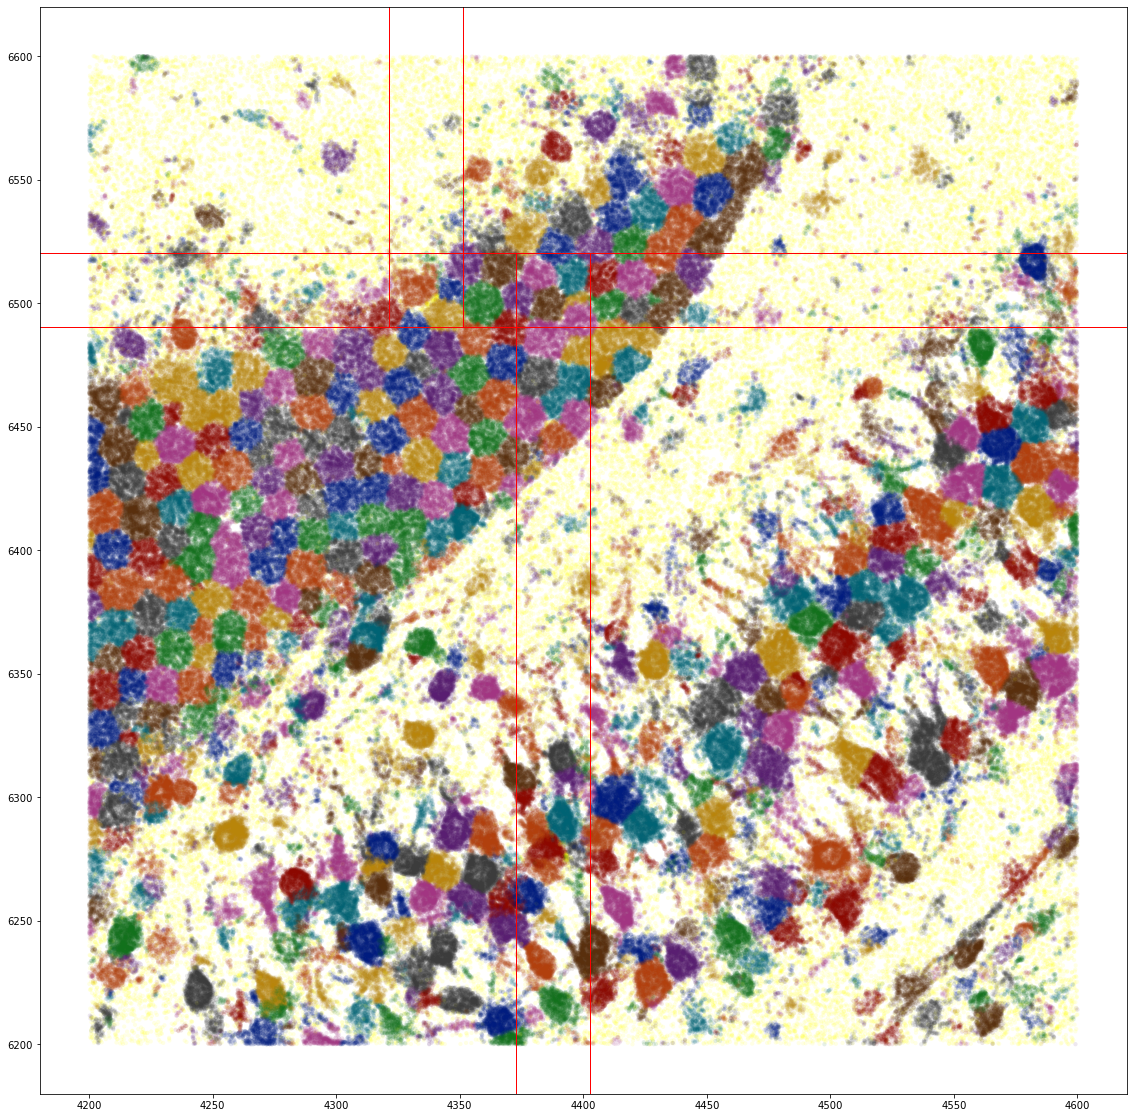

In [24]:
fig, ax = plt.subplots(figsize=(20, 20))
region = spot_table.get_subregion((4200, 4600), (6200, 6600))
region.cell_scatter_plot(ax=ax, alpha=0.1)
for tile in tiles:
    tile.plot_rect(ax=ax, color='r')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
region = spot_table.get_subregion((2200, 2600), (4200, 4600))
region.cell_scatter_plot(ax=ax, alpha=0.1)
for tile in tiles:
    tile.plot_rect(ax=ax, color='r')